In [1]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [2]:
from langchain_community.tools import TavilySearchResults 

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

C:\Users\wogus\AppData\Local\Temp\ipykernel_58012\536836938.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [3]:
def web_search(state: AgentState) -> AgentState:
    query = state["query"]
    search_result = tavily_search_tool.invoke(query)
    return {"context": search_result}

In [4]:
from langchain_openai import ChatOpenAI
from langchain import hub

web_generate_prompt = hub.pull('rlm/rag-prompt')
llm = ChatOpenAI(model="gpt-4o")
small_llm = ChatOpenAI(model="gpt-4o-mini")
router_llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
def web_generate(state: AgentState) -> AgentState:
    query = state["query"]
    context = state["context"]
    web_generate_chain = web_generate_prompt | llm
    response = web_generate_chain.invoke({"question": query, "context": context})

    return {"answer": response}

In [6]:
def basic_generate(state: AgentState) -> AgentState:
    query = state["query"]
    response = small_llm.invoke(query)
    return {"answer": response}

In [7]:
from langchain_core.tools import structured
from typing_extensions import Literal
from pydantic import Field, BaseModel
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

class route(BaseModel):
    target: Literal["vector_store", "llm", "web_search"] = Field(
        description="사용자의 질문에 대답하기 위한 타겟입니다."
        )

router_prompt_template = """
    You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'.
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_prompt_template),
    ("user", "{query}")
])

structured_llm = router_llm.with_structured_output(route)

def router(state: AgentState) -> Literal["vector_store", "llm", "web_search"]:
    query = state["query"]
    router_chains = router_prompt | structured_llm
    response = router_chains.invoke({"query": query})
    print("target ==", response)
    return response.target

In [8]:
query = "소득세법에 대해서 알려줘"

In [9]:
initial_state = {"query": query}

In [10]:
router(initial_state)

target == target='vector_store'


'vector_store'

In [11]:
from langgraph.graph import END, START
from income_tax_graph_jh  import graph as income_tax_subgraph

graph_builder.add_node("web_search", web_search)
graph_builder.add_node("web_generate", web_generate)
graph_builder.add_node("basic_generate", basic_generate)
# graph_builder.add_node("router", router)
graph_builder.add_node("income_tax_subgraph", income_tax_subgraph)


graph_builder.add_conditional_edges(START, router, 
                                {"vector_store": "income_tax_subgraph", 
                                "llm": "basic_generate", 
                                "web_search": "web_search"})
graph_builder.add_edge("basic_generate", END)
graph_builder.add_edge("web_search", "web_generate")
graph_builder.add_edge("web_generate", END)
graph_builder.add_edge("income_tax_subgraph", END)

graph = graph_builder.compile()

c:\dev2\AI_Agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


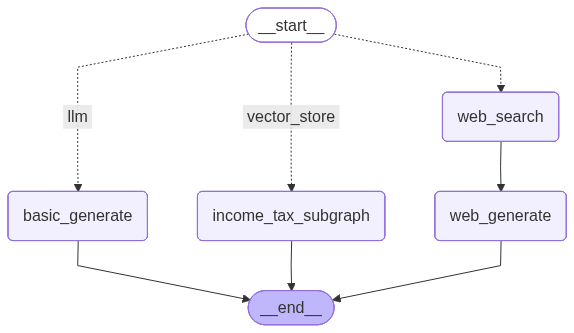

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
query = "역삼동 맛집을 추천해줘"

In [14]:
initial_state = {"query": query}

In [15]:
graph.invoke(initial_state)

target == target='web_search'


{'query': '역삼동 맛집을 추천해줘',
 'context': [{'title': '역삼역 주변 맛집 리스트 - pangpang - 티스토리',
   'url': 'https://sam-repository.tistory.com/11',
   'content': "한 줄 평가:매운 음식을 좋아한다면 도전해볼만한 뼈숯불구이!\n\n매운 음식을 좋아한다면 신동궁감자탕 역삼직영점에서 매운 뼈숯불구이 를 도전해보시는 건 어떨까요? 꽤 매운 편 이라서 호불호가 갈릴 수 있으니 꼭! 매운 음식을 좋아하는 사람들이랑 가는 것을 추천드려요. 등뼈 사이사이에 낀 살이 부드럽게 발라지고, 중간중간 양배추 샐러드를 곁들여 먹거나 밥이랑 비벼 먹어도 좋아요. 다만 6시를 기준으로 사람들이 물밀 듯이 갈 수 있으니 웨이팅을 해야 할 수도 있습니다.\n\n  \n\n이상으로 역삼역 주변 맛집 리스트를 정리해보았는데요, 이번 글을 읽고 역삼역 인근의 맛집을 찾는데 도움이 되셨으면 좋겠습니다! 이상 읽어주셔서 감사합니다. 😁😁\n\n공유하기\n\nURL 복사 카카오톡 공유 페이스북 공유 엑스 공유\n\n게시글 관리\n\n_구독하기_pangpang\n\n#### 'SSAFY>SSAFYcial' 카테고리의 다른 글 [...] 키워드:#술 #플래터 #맥주 #하이볼 #논알콜도있어요 #와인 #단체회식\n\n도로명주소:서울 강남구 테헤란로33길 18 1층\n\n맛있게 먹은 사람:76.19%(432 / 567)\n\n한 줄 평가:눈이 즐거워지는 대용량 플래터 와 인테리어가 인상적인 맥주집!\n\n맥주, 하이볼, 와인, 논알콜 다양한 종류가 있어서 주종 상관 없이 취향껏 즐길 수 있어요. 무엇보다 여러 명이서 가서 플래터를 하나 시키면 맛있고 양이 많아서 남녀노소 누구나 즐길 수 있는 술집입니다. 뿐만 아니라 인테리어, 화장실도 깔끔해서 역삼역 회식 장소로 강추!\n\n10. 신동궁감자탕 역삼직영점\n--------------------\n\nImage 12\n\n역삼역 맛집 10. 신동궁감자탕 역